# Generate figure for JOSS paper

__authors__: @aymgal

__created on__: 27/04/23

__last update__: 27/04/23

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, TwoSlopeNorm
from pprint import pprint

from coolest.api.analysis import Analysis
from coolest.api.plotting import ModelPlotter, MultiModelPlotter
from coolest.api import util

In [2]:
def print_info(coolest_object):
    source_index = 2  # index of the source galaxy in the list of `lensing entities`
    print("Lensing entities:", [type(le).__name__ for le in coolest_object.lensing_entities])
    print("Source light model:", [type(m).__name__ for m in coolest_object.lensing_entities[source_index].light_model])

## Load the lens models stored in COOLEST format

### Code n°1, based on an analytical source model

In [3]:
code_1_path = 'database/code_1/coolest_code_1'
coolest_1 = util.get_coolest_object(code_1_path, verbose=False)
print_info(coolest_1)

Lensing entities: ['ExternalShear', 'Galaxy', 'Galaxy']
Source light model: ['Sersic', 'Shapelets']


### Code n°2, based on pixelated source model on a regular grid

In [4]:
code_2_path = 'database/code_2/coolest_code_2'
coolest_2 = util.get_coolest_object(code_2_path, verbose=False)
print_info(coolest_2)

Lensing entities: ['ExternalShear', 'Galaxy', 'Galaxy']
Source light model: ['PixelatedRegularGrid']


### Code n°3, based on pixelated source model on an irregular grid

In [5]:
code_3_path = 'database/code_3/coolest_code_3'
coolest_3 = util.get_coolest_object(code_3_path, verbose=False)
print_info(coolest_3)

Lensing entities: ['ExternalShear', 'Galaxy', 'Galaxy']
Source light model: ['IrregularGrid']


## Setup a custom coordinates

so that we can evaluate light profiles consistently on that specific coordinates grid. 

In [6]:
coord_orig = util.get_coordinates(coolest_1)
x_orig, y_orig = coord_orig.pixel_coordinates
print(coord_orig.plt_extent)

coord_src = coord_orig.create_new_coordinates(pixel_scale_factor=0.1, grid_shape=(2, 2))
x_src, y_src = coord_src.pixel_coordinates
print(coord_src.plt_extent)

[-5.0, 5.0, -5.0, 5.0]
[-1.005, 0.9950000000000004, -1.0050000000000001, 0.9950000000000002]


## Compute effective quantities

In [7]:
analysis_1 = Analysis(coolest_1, code_1_path, supersampling=5)
analysis_2 = Analysis(coolest_2, code_2_path, supersampling=5)
analysis_3 = Analysis(coolest_3, code_3_path, supersampling=5)

### Effective radius of the source surface brigtness

In [8]:
r_eff_src_1 = analysis_1.effective_radius_light(center=(0, 0), coordinates=coord_src, 
                                                outer_radius=1., entity_selection=[2])
print(r_eff_src_1)

r_eff_src_2 = analysis_2.effective_radius_light(center=(0, 0), coordinates=coord_src, 
                                                outer_radius=1., entity_selection=[2])
print(r_eff_src_2)

r_eff_src_3 = analysis_3.effective_radius_light(center=(0, 0), coordinates=coord_src, 
                                                outer_radius=1., entity_selection=[2])
print(r_eff_src_3)

0.4187499999999995
0.36874999999999947
0.36874999999999947


/Users/aymgal/Science/packages/my_packages/coolest/coolest/api/analysis.py:211: UserWarning: Warning: Outer limit of integration exceeds FoV; effective radius may not be accurate.
  warnings.warn("Warning: Outer limit of integration exceeds FoV; effective radius may not be accurate.")


### Effective Einstein radius

In [9]:
theta_E_1 = analysis_1.effective_einstein_radius(entity_selection=[0, 1])
print(theta_E_1)

theta_E_2 = analysis_2.effective_einstein_radius(entity_selection=[0, 1])
print(theta_E_2)

theta_E_3 = analysis_3.effective_einstein_radius(entity_selection=[0, 1])
print(theta_E_3)

INFO:root:Picked center from profile 'PEMD'
INFO:root:Picked center from profile 'PEMD'
INFO:root:Picked center from profile 'PEMD'


1.5499999999999883
1.5750000000000006
1.5625000000000007


## Generate the comparison figure

### Instantiate the plotter engines

In [10]:
#x_src, y_src = np.meshgrid(np.linspace(-1, 1, 20), np.linspace(-1, 1, 20))

# initialize the Plotters
mplotter = MultiModelPlotter(
    [coolest_1, coolest_2, coolest_3],
    coolest_directories=[
        os.path.dirname(code_1_path), 
        os.path.dirname(code_2_path), 
        os.path.dirname(code_3_path)
    ]
)
splotter_2 = ModelPlotter(coolest_2, coolest_directory=os.path.dirname(code_2_path))
splotter_3 = ModelPlotter(coolest_3, coolest_directory=os.path.dirname(code_3_path))

### Select what to plot on which axes, and show final plot

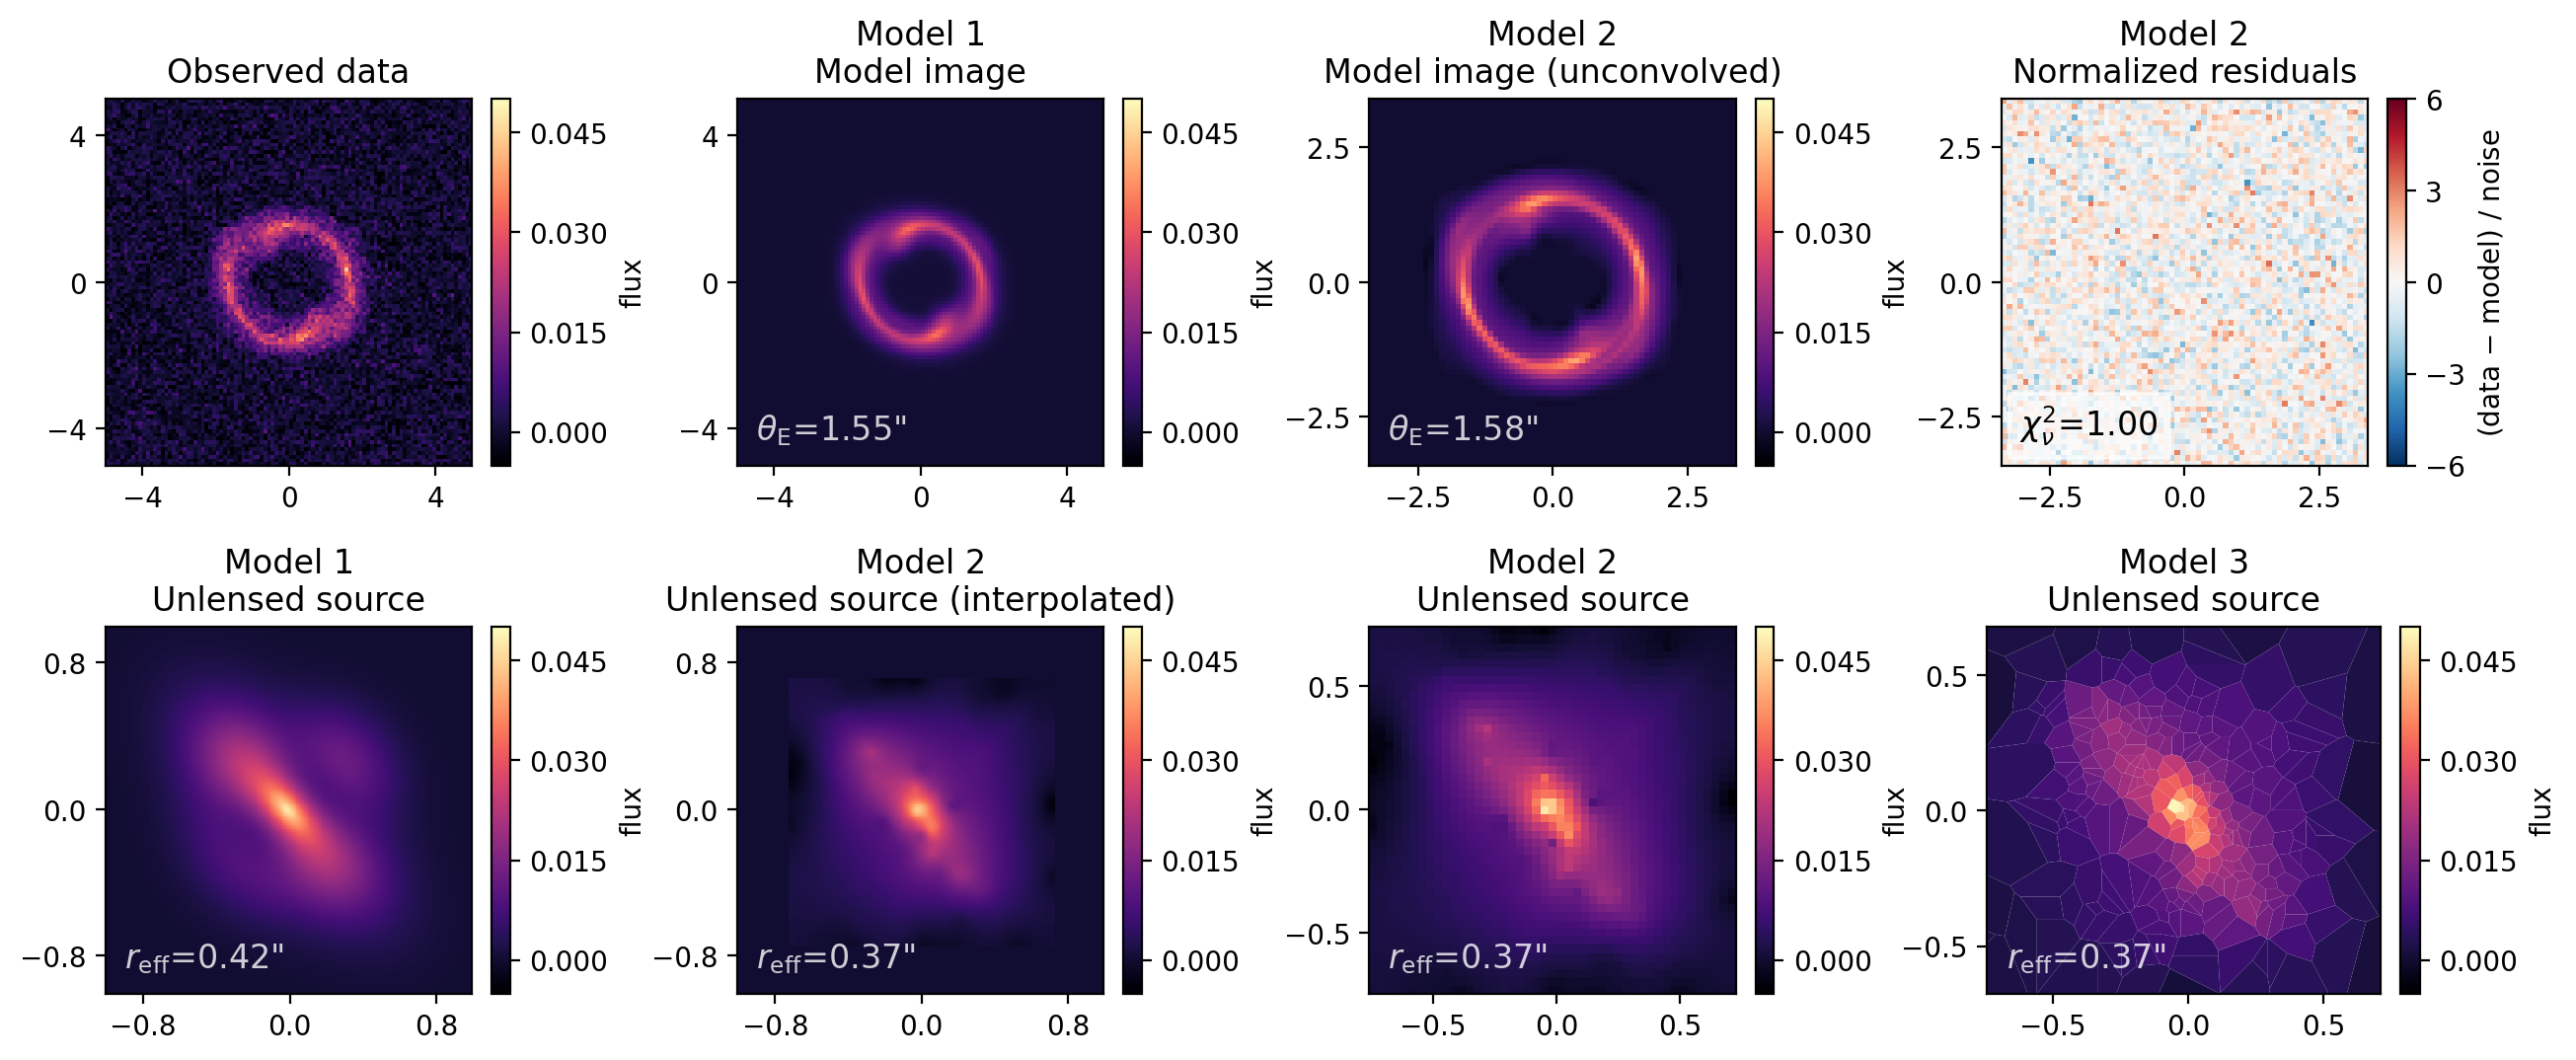

In [15]:
norm = Normalize(-0.005, 0.05) # LogNorm(2e-3, 5e-2)

# create the figure
fig, axes = plt.subplots(2, 4, figsize=(14, 5.5))

# multi-plotter panels
mplotter.plot_data_image(
    [axes[0, 0], None, None],
    titles=["Observed data", None, None],
    norm=norm
)
mplotter.plot_model_image(
    [axes[0, 1], None, None],
    titles=["Model 1\nModel image", None, None],
    supersampling=5, convolved=True,
    kwargs_source=dict(entity_selection=[[2], [2], [2]]),
    kwargs_lens_mass=dict(entity_selection=[[0, 1], [0, 1], [0, 1]]),
    norm=norm
)
axes[0, 1].text(0.05, 0.05, r'$\theta_{\rm E}$='+f'{theta_E_1:.2f}"', color='white', fontsize=12, alpha=0.8, 
                va='bottom', ha='left', transform=axes[0, 1].transAxes)
mplotter.plot_model_image(
    [None, axes[0, 2], None],
    titles=[None, "Model 2\nModel image (unconvolved)", None],
    supersampling=5, convolved=False,
    kwargs_source=dict(entity_selection=[[2], [2], [2]]),
    kwargs_lens_mass=dict(entity_selection=[[0, 1], [0, 1], [0, 1]]),
    norm=norm
)
axes[0, 2].text(0.05, 0.05, r'$\theta_{\rm E}$='+f'{theta_E_2:.2f}"', color='white', fontsize=12, alpha=0.8, 
                va='bottom', ha='left', transform=axes[0, 2].transAxes)
mplotter.plot_model_residuals(
    [None, axes[0, 3], None],
    titles=[None, "Model 2\nNormalized residuals", None],
    supersampling=5, add_chi2_label=True, chi2_fontsize=12,
    kwargs_source=dict(entity_selection=[[2], [2], [2]]),
    kwargs_lens_mass=dict(entity_selection=[[0, 1], [0, 1], [0, 1]]),
)
res = mplotter.plot_surface_brightness(
    [axes[1, 0], axes[1, 1], None], 
    titles=[
        "Model 1\nUnlensed source", 
        "Model 2\nUnlensed source (interpolated)", 
        None, #"Model 3: source model", 
    ],
    kwargs_light=dict(entity_selection=[[2], [2], [2]]),
    norm=norm,
    neg_values_as_bad=False,
    coordinates=coord_src,
)
axes[1, 0].text(0.05, 0.05, r'$r_{\rm eff}$='+f'{r_eff_src_1:.2f}"', color='white', fontsize=12, alpha=0.8, 
                va='bottom', ha='left', transform=axes[1, 0].transAxes)
axes[1, 1].text(0.05, 0.05, r'$r_{\rm eff}$='+f'{r_eff_src_2:.2f}"', color='white', fontsize=12, alpha=0.8, 
                va='bottom', ha='left', transform=axes[1, 1].transAxes)

# single-plotter panels
splotter_2.plot_surface_brightness(
    axes[1, 2], 
    title="Model 2\nUnlensed source",
    kwargs_light=dict(entity_selection=[2]),
    norm=norm,
    neg_values_as_bad=False,
)
axes[1, 2].text(0.05, 0.05, r'$r_{\rm eff}$='+f'{r_eff_src_2:.2f}"', color='white', fontsize=12, alpha=0.8, 
                va='bottom', ha='left', transform=axes[1, 2].transAxes)
splotter_3.plot_surface_brightness(
    axes[1, 3], 
    title="Model 3\nUnlensed source",
    kwargs_light=dict(entity_selection=[2]),
    norm=norm,
    neg_values_as_bad=False,
)
axes[1, 3].text(0.05, 0.05, r'$r_{\rm eff}$='+f'{r_eff_src_3:.2f}"', color='white', fontsize=12, alpha=0.8, 
                va='bottom', ha='left', transform=axes[1, 3].transAxes)

fig.tight_layout()
fig.subplots_adjust(
    wspace=0.02,
    #hspace=0.15,
)
plt.show()

# uncomment to save figure
fig.savefig("coolest_plot_example.png", dpi=150, bbox_inches='tight')